## Derive emission based historical ERFs:
We use timeseries for historical emissions/concentrations and then scale these with the 1750-2019 ERF from Thornhill (2019)/bill collins plot to derive ERF timeseries. 
For short lived components, we use change in emissions from CEDS:
- NOx, VOC/CO, SO2, OC, BC, NH3

For longer lived components, we use change in concentrations from chap 2:
- CO2, CH4, N2O, HC

For ERF from VOC/CO we use emissions of CO to scale. 
For HC we use the HC from Thornhill (which includes only CFCs and HCFCs) and additionally, we use HFC concentrations (ch2) and multipy with radiative efficiencies (RE) from Hodnebrog et al (2019). 
HC is then the sum of the HC from Thornhill (scaled with concentrations) and the HFC ERF.

Finally, these ERFs are integrated with the IRF and the change in GSAT is calculated. 


### References:
Hodnebrog, Ø, B. Aamaas, J. S. Fuglestvedt, G. Marston, G. Myhre, C. J. Nielsen, M. Sandstad, K. P. Shine, and T. J. Wallington. “Updated Global Warming Potentials and Radiative Efficiencies of Halocarbons and Other Weak Atmospheric Absorbers.” Reviews of Geophysics 58, no. 3 (2020): e2019RG000691. https://doi.org/10.1029/2019RG000691


Thornhill, Gillian D., William J. Collins, Ryan J. Kramer, Dirk Olivié, Ragnhild B. Skeie, Fiona M. O’Connor, Nathan Luke Abraham, et al. “Effective Radiative Forcing from Emissions of Reactive Gases and Aerosols – a Multi-Model Comparison.” Atmospheric Chemistry and Physics 21, no. 2 (January 21, 2021): 853–74. https://doi.org/10.5194/acp-21-853-2021.

## Final ERFs in 2019 based on Thornhill 2021

<img src="../../results/figures_historic_attribution/attribution_1750_2019_5-95th.png" alt="drawing" width="800"/>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ar6_ch6_rcmipfigs.constants import INPUT_DATA_DIR_BADC, INPUT_DATA_DIR, \
    OUTPUT_DATA_DIR, RESULTS_DIR
from ar6_ch6_rcmipfigs.utils.badc_csv import read_csv_badc

/Users/sarablichner/science/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs
/Users/sarablichner/science/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_in


### File paths

In [2]:
fn_concentrations = INPUT_DATA_DIR / 'historical_delta_GSAT/LLGHG_history_AR6_v9_updated.xlsx'
path_emissions = INPUT_DATA_DIR / 'historical_delta_GSAT/CEDS_v2021-02-05_emissions/'

# file path table of ERF 2019-1750
fp_collins = RESULTS_DIR / 'tables_historic_attribution/table_mean_smb_orignames.csv'

In [3]:
fl_CEDS = list(path_emissions.glob('*global_CEDS_emissions_by_sector_2021_02_05.csv'))

### Output file paths:

In [4]:
fn_output_ERF = OUTPUT_DATA_DIR / 'historic_delta_GSAT/hist_ERF_est.csv'
fn_output_ERF_2019 = OUTPUT_DATA_DIR / 'historic_delta_GSAT/2019_ERF_est.csv'
fn_output_decomposition = OUTPUT_DATA_DIR / 'historic_delta_GSAT/hist_ERF_est_decomp.csv'

## Load concentration file and interpolate from 1750 to 1850

In [5]:

df_conc = pd.read_excel(fn_concentrations, header=22, index_col=0, engine='openpyxl')
# adds unnecessary row with nans and unnamed columns
df_conc = df_conc.loc[1750:2019]
unnamed = [c for c in df_conc.columns if 'Unnamed:' in c]
df_conc = df_conc.drop(unnamed, axis=1)

# For C8F18 there appears to be an error in the spreadsheet where 2015 is entered as zero, presumably 0.09 but treat as missing
df_conc.loc[2015, 'C8F18'] = np.nan

# datetime index
df_conc.index = pd.to_datetime(df_conc.index.astype(int), format='%Y')

# resample to yearly, i.e. NaNs will be filled between 1750 and 1850:
df_conc = df_conc.resample('Y').first()  # .interpolate()
# Interpolate:
df_conc = df_conc.interpolate(method='linear',
                              limit_area='inside')  # 'inside' only fill values with valid on both sides.
# reset index to year
df_conc.index = df_conc.index.year
df_conc

,CO2,CH4,N2O,HFC-134a,HFC-23,HFC-32,HFC-125,HFC-143a,HFC-152a,HFC-227ea,...,i-C6F14,C7F16,C8F18,CFC-112,CFC-112a,CFC-113a,CFC-114a,HCFC-133a,HCFC-31,HCFC-124
YYYY,,,,,,,,,,,,,,,,,,,,,
1750,278.300,729.2000,270.1000,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.000,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.0,0.00
1751,278.372,729.9840,270.1200,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.000,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.0,0.00
1752,278.444,730.7680,270.1400,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.000,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.0,0.00
1753,278.516,731.5520,270.1600,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.000,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.0,0.00
1754,278.588,732.3360,270.1800,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.000,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,399.420,1834.0055,328.3025,83.4145,28.042,9.985158,18.0910,17.5655,6.5970,1.096239,...,0.062,0.11,NaN,0.412,0.066,0.68,1.05,0.39897,NaN,1.02
2016,402.850,1842.1665,329.1240,89.4825,28.950,11.972602,20.4815,19.1555,6.6600,1.205802,...,NaN,NaN,NaN,NaN,0.067,NaN,1.04,0.42501,NaN,NaN
2017,405.000,1849.2365,330.0400,95.7485,29.975,14.153317,23.2450,20.8340,6.8175,1.327504,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.43989,NaN,NaN


In [6]:
[c for c in df_conc.columns if 'CFC' in c]

['CFC-12',
 'CFC-11',
 'CFC-113',
 'CFC-114',
 'CFC-115',
 'CFC-13',
 'HCFC-22',
 'HCFC-141b',
 'HCFC-142b',
 'CFC-112',
 'CFC-112a',
 'CFC-113a',
 'CFC-114a',
 'HCFC-133a',
 'HCFC-31',
 'HCFC-124']

## Emissions:

In [7]:
list_df_em = []
units_dic = {}
for fn in fl_CEDS:
    _df = pd.read_csv(fn)
    u_em = _df['em'].unique()
    if len(u_em) > 1:
        print('double check, emission labels :')
        print(u_em)
    _em = u_em[0]
    u_units = _df['units'].unique()
    if len(u_units) > 1:
        print('double check, units labels :')
        print(u_units)
    _un = u_units[0]
    _df_s = _df.drop(['em', 'sector', 'units'], axis=1).sum()
    _df_s.index = pd.to_datetime(_df_s.index, format='X%Y').year
    _df = pd.DataFrame(_df_s, columns=[_em])
    units_dic[_em] = _un
    list_df_em.append(_df)

In [8]:
df_emissions = pd.concat(list_df_em, axis=1)

In [9]:
df_emissions

,CO2,CO,N2O,OC,NOx,NMVOC,CH4,SO2,NH3,BC
1750,8.576757e+03,67762.973185,NaN,2227.719109,185.580971,7023.641263,NaN,328.789104,3269.176758,515.765609
1751,8.576757e+03,67946.051473,NaN,2234.522070,186.076547,7042.533954,NaN,333.628884,3278.144906,516.971538
1752,8.580118e+03,68128.860406,NaN,2241.318148,186.576018,7061.396094,NaN,337.206293,3287.111716,518.178349
1753,8.580118e+03,68311.163486,NaN,2248.101520,187.070914,7080.216581,NaN,340.229988,3296.077167,519.381789
1754,8.583478e+03,68493.197158,NaN,2254.878009,187.569704,7099.006515,NaN,343.545708,3305.041280,520.586112
...,...,...,...,...,...,...,...,...,...,...
2015,3.450186e+07,565944.477777,9583.586380,13800.102858,124803.357256,149389.741081,359770.677166,91935.652997,59038.504361,6032.311194
2016,3.449306e+07,548345.493004,9577.935584,13823.964613,123173.953426,148702.416915,357309.033465,88171.800222,59617.940857,5930.684820
2017,3.498511e+07,541357.744387,9610.590560,13826.957269,123024.332504,148911.160658,357485.146366,84928.764295,60261.516203,5927.165439
2018,3.586313e+07,536103.071094,9692.574706,13746.675390,122148.081545,147892.709851,360716.548043,84446.146636,60791.374593,5889.262292


In [10]:
units_dic

{'CO2': 'ktCO2',
 'CO': 'ktCO',
 'N2O': 'ktN2O',
 'OC': 'ktC',
 'NOx': 'ktNO2',
 'NMVOC': 'ktNMVOC',
 'CH4': 'ktCH4',
 'SO2': 'ktSO2',
 'NH3': 'ktNH3',
 'BC': 'ktC'}

## Load CMIP ERFs (bill collins)

In [11]:
df_collins = pd.read_csv(fp_collins, index_col=0)
df_collins.index = df_collins.index.rename('emission_experiment')

In [12]:
df_collins  # .columns

,CO2,CH4_lifetime,Strat_H2O,Aerosol,Cloud,O3,HC,N2O
emission_experiment,,,,,,,,
CO2,2.057554,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00
CH4,0.017549,0.844457,0.05,-0.002653,0.018421,0.266736,0.00,0.00
N2O,0.000000,-0.035967,0.00,-0.002090,0.042503,0.026124,0.00,0.21
HC,0.000053,-0.050927,0.00,-0.008080,-0.017419,-0.162033,0.41,0.00
NOx,0.000000,-0.380025,0.00,-0.009166,-0.014458,0.137102,0.00,0.00
VOC,0.069491,0.162462,0.00,-0.002573,0.008884,0.202071,0.00,0.00
SO2,0.000000,0.000000,0.00,-0.234228,-0.703784,0.000000,0.00,0.00
OC,0.000000,0.000000,0.00,-0.072143,-0.136919,0.000000,0.00,0.00
BC,0.000000,0.000000,0.00,0.144702,-0.037227,0.000000,0.00,0.00


In [13]:
df_collins.sum()  # .columns

CO2             2.144647
CH4_lifetime    0.540000
Strat_H2O       0.050000
Aerosol        -0.220000
Cloud          -0.840000
O3              0.470000
HC              0.410000
N2O             0.210000
dtype: float64

In [14]:
forcing_total_collins = df_collins.sum(axis=1)  # ['Total']
forcing_total_collins

emission_experiment
CO2    2.057554
CH4    1.194509
N2O    0.240569
HC     0.171594
NOx   -0.266546
VOC    0.440334
SO2   -0.938012
OC    -0.209062
BC     0.107475
NH3   -0.033769
dtype: float64

In [15]:
def scale_ERF(forcing_tot, df_agent, spec_lab, spec_cmip, end_year=2019, base_year=1750):
    """
    Scale ERF forcing in the end year (2019) by the concentrations/emissions each year
    divided by the concentration/emission in the end year (relative to the base year).
    :param forcing_tot:
    :param df_agent:
    :param spec_lab:
    :param spec_cmip:
    :param end_year:
    :param base_year:
    :return:
    """
    delta_spec_end_year = df_agent[spec_lab].loc[end_year] - df_agent[spec_lab].loc[base_year]  # 2019
    delta_spec = df_agent[spec_lab] - df_agent[spec_lab].loc[base_year]  # 1750-2019
    aerchemmip_endyear_forcing = forcing_tot[spec_cmip]  # from Bill collins
    erf_spec = aerchemmip_endyear_forcing * delta_spec / delta_spec_end_year  # scale by concentrations
    return erf_spec

CO2
N2O
CH4


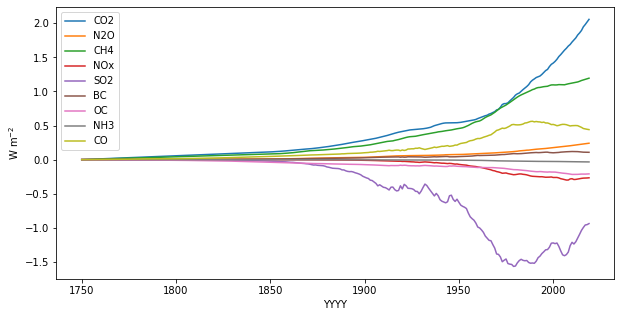

In [16]:
fig, ax = plt.subplots(figsize=[10, 5])

ERFs = {}
for spec in ['CO2', 'N2O', 'CH4']:
    forcing_spec = scale_ERF(forcing_total_collins, df_conc, spec, spec)  # # scale by concentrations

    print(spec)
    forcing_spec.plot(label=spec)
    ERFs[spec] = forcing_spec

spec = 'NOx'
for spec in ['NOx', 'SO2', 'BC', 'OC', 'NH3']:
    forcing_spec = scale_ERF(forcing_total_collins, df_emissions, spec, spec)  # scale by emissions

    ERFs[spec] = forcing_spec

    forcing_spec.plot(label=spec)

# VOC: scale with CO emissions because these are mostly the same
spec = 'CO'

forcing_spec = scale_ERF(forcing_total_collins, df_emissions, spec, 'VOC')  # scale by concentrations

ERFs['VOC'] = forcing_spec

forcing_spec.plot(label=spec)

plt.ylabel('W m$^{-2}$')

plt.legend(loc='upper left')

## HFCs:
For HFCs we use the RE from Hodnebrog et al 2019 and the concentrations from chapter two to calculate the ERF. 

### Hodnebrog et al:

Read in table 3 from Hodnebrog et al 

In [17]:
fp_hodnebrog = INPUT_DATA_DIR_BADC / 'hodnebrog_tab3.csv'
#fp_hodnebrog = INPUT_DATA_DIR / 'hodnebrog_tab3.csv'

In [18]:
df_hodnebrog = read_csv_badc(fp_hodnebrog, index_col=[0, 1], header=[0, 1])
df_HFC = df_hodnebrog.loc[('Hydrofluorocarbons',)]
df_HFC

/Users/sarablichner/miniconda3/envs/rcmip_ch6/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  


Info                        Info              tau (yr)             \
Identifier/name          Formula        CASRN   H2013a WMO (2019)   
HFC-23                      CHF3      75-46-7    222.0      228.0   
HFC-32                     CH2F2      75-10-5      5.2        5.4   
HFC-125                  CHF2CF3     354-33-6     28.2       30.0   
HFC-134a                 CH2FCF3     811-97-2     13.4       14.0   
HFC-143a                  CH3CF3     420-46-2     47.1       51.0   
HFC-152a                 CH3CHF2      75-37-6      1.5        1.6   
HFC-227ea              CF3CHFCF3     431-89-0     38.9       36.0   
HFC-236fa              CF3CH2CF3     690-39-1    242.0      213.0   
HFC-245fa             CHF2CH2CF3     460-73-1      7.7        7.9   
HFC-365mfc          CH3CF2CH2CF3     406-58-6      8.7        8.9   
HFC-43-10mee     CF3CHFCHFCF2CF3  138495-42-8     16.1       17.0   

Info            RE (Wm-2ppb-1)           GWP(100)            
Identifier/name          H2013 This work    H2013 This work  
HFC-23                    0.17      0.19    12400   15500.0  
HFC-32                    0.11      0.11      677     809.0  
HFC-125                   0.23      0.23     3170    3940.0  
HFC-134a                  0.16      0.17     1300    1600.0  
HFC-143a                  0.16      0.17     4800    6130.0  
HFC-152a                  0.10      0.10      138     172.0  
HFC-227ea                 0.26      0.27     3350    3800.0  
HFC-236fa                 0.24      0.25     8060    9210.0  
HFC-245fa                 0.24      0.24      858    1010.0  
HFC-365mfc                0.22      0.23      804     959.0  
HFC-43-10mee              0.42      0.36     1650    1680.0

df_hodnebrog = pd.read_csv(fp_hodnebrog, index_col=[0, 1], header=[7, 8])
df_HFC = df_hodnebrog.loc[('Hydrofluorocarbons',)]
df_HFC

df_hodnebrog = pd.read_csv(fp_hodnebrog, index_col=[0, 1], header=[0, 1])
df_HFC = df_hodnebrog.loc[('Hydrofluorocarbons',)]
df_HFC

In [19]:
RE_df = df_HFC['RE (Wm-2ppb-1)'].transpose()
# RE_df = RE_df.reset_index().rename({'level_1':'Species'},axis=1).set_index('Species').drop('level_0', axis=1)
RE_df  # .transpose().loc['This work']*

,HFC-23,HFC-32,HFC-125,HFC-134a,HFC-143a,HFC-152a,HFC-227ea,HFC-236fa,HFC-245fa,HFC-365mfc,HFC-43-10mee
Identifier/name,,,,,,,,,,,
H2013,0.17,0.11,0.23,0.16,0.16,0.1,0.26,0.24,0.24,0.22,0.42
This work,0.19,0.11,0.23,0.17,0.17,0.1,0.27,0.25,0.24,0.23,0.36


In [20]:
df_conc[RE_df.columns] - df_conc[RE_df.columns].loc[1750]

,HFC-23,HFC-32,HFC-125,HFC-134a,HFC-143a,HFC-152a,HFC-227ea,HFC-236fa,HFC-245fa,HFC-365mfc,HFC-43-10mee
YYYY,,,,,,,,,,,
1750,0.000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000,0.000,0.000000,0.000
1751,0.000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000,0.000,0.000000,0.000
1752,0.000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000,0.000,0.000000,0.000
1753,0.000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000,0.000,0.000000,0.000
1754,0.000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000,0.000,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
2015,28.042,9.984940,18.0910,83.4145,17.5655,6.5970,1.096235,0.142,2.232,0.855653,0.254
2016,28.950,11.972384,20.4815,89.4825,19.1555,6.6600,1.205798,0.153,2.426,0.931363,0.264
2017,29.975,14.153098,23.2450,95.7485,20.8340,6.8175,1.327500,0.166,2.636,0.990426,0.272


In [21]:
ERF_HFCs = (df_conc[RE_df.columns] - df_conc[RE_df.columns].loc[1750]) * RE_df.loc['This work'] * 1e-3  # ppt to ppb
ERF_HFCs['HFCs'] = ERF_HFCs.sum(axis=1)
ERF_HFCs

,HFC-23,HFC-32,HFC-125,HFC-134a,HFC-143a,HFC-152a,HFC-227ea,HFC-236fa,HFC-245fa,HFC-365mfc,HFC-43-10mee,HFCs
YYYY,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1751,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1753,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1754,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2015,0.005328,0.001098,0.004161,0.014180,0.002986,0.000660,0.000296,0.000035,0.000536,0.000197,0.000091,0.029569
2016,0.005501,0.001317,0.004711,0.015212,0.003256,0.000666,0.000326,0.000038,0.000582,0.000214,0.000095,0.031918
2017,0.005695,0.001557,0.005346,0.016277,0.003542,0.000682,0.000358,0.000042,0.000633,0.000228,0.000098,0.034457


Text(0, 0.5, 'W/m2')

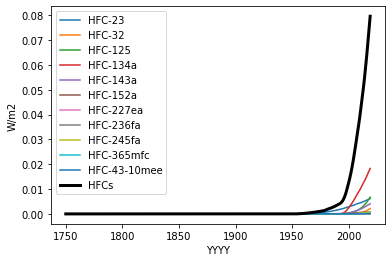

In [22]:
for c in ERF_HFCs.columns[:-1]:
    ERF_HFCs[c].plot(label=c)
ERF_HFCs.sum(axis=1).plot(label='HFCs', color='k', linewidth=3)
plt.legend()
plt.ylabel('W/m2')

In [23]:
# We use CFC-12 emissions for HC
spec = 'CFC-12'
forcing_HC = scale_ERF(forcing_total_collins, df_conc, spec, 'HC')  # scale by concentrations

ERFs['HC'] = forcing_HC + ERF_HFCs['HFCs']

ERF_HFCs['HFCs']

YYYY
1750    0.000000
1751    0.000000
1752    0.000000
1753    0.000000
1754    0.000000
          ...   
2015    0.029569
2016    0.031918
2017    0.034457
2018    0.037082
2019    0.039772
Name: HFCs, Length: 270, dtype: float64

In [24]:
df_ERF = pd.concat(ERFs, axis=1)  # ['CO2'].loc[1752]
df_ERF.columns

Index(['CO2', 'N2O', 'CH4', 'NOx', 'SO2', 'BC', 'OC', 'NH3', 'VOC', 'HC'], dtype='object')

In [25]:
forcing_HC[2019]

0.1715940407786291

### Add HFC to dataset

In [26]:
df_collins['HFCs'] = 0
df_collins.loc['HC', 'HFCs'] = ERF_HFCs['HFCs'][2019]
df_collins

,CO2,CH4_lifetime,Strat_H2O,Aerosol,Cloud,O3,HC,N2O,HFCs
emission_experiment,,,,,,,,,
CO2,2.057554,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000
CH4,0.017549,0.844457,0.05,-0.002653,0.018421,0.266736,0.00,0.00,0.000000
N2O,0.000000,-0.035967,0.00,-0.002090,0.042503,0.026124,0.00,0.21,0.000000
HC,0.000053,-0.050927,0.00,-0.008080,-0.017419,-0.162033,0.41,0.00,0.039772
NOx,0.000000,-0.380025,0.00,-0.009166,-0.014458,0.137102,0.00,0.00,0.000000
VOC,0.069491,0.162462,0.00,-0.002573,0.008884,0.202071,0.00,0.00,0.000000
SO2,0.000000,0.000000,0.00,-0.234228,-0.703784,0.000000,0.00,0.00,0.000000
OC,0.000000,0.000000,0.00,-0.072143,-0.136919,0.000000,0.00,0.00,0.000000
BC,0.000000,0.000000,0.00,0.144702,-0.037227,0.000000,0.00,0.00,0.000000


In [27]:
df_collins.sum(axis=0)

CO2             2.144647
CH4_lifetime    0.540000
Strat_H2O       0.050000
Aerosol        -0.220000
Cloud          -0.840000
O3              0.470000
HC              0.410000
N2O             0.210000
HFCs            0.039772
dtype: float64

In [28]:
df_ERF

,CO2,N2O,CH4,NOx,SO2,BC,OC,NH3,VOC,HC
1750,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000
1751,0.001126,0.000078,0.000824,-0.000001,-0.000055,0.000024,-0.000125,-0.000005,0.000174,0.000000
1752,0.002252,0.000155,0.001647,-0.000002,-0.000095,0.000049,-0.000249,-0.000010,0.000348,0.000000
1753,0.003378,0.000233,0.002471,-0.000003,-0.000130,0.000073,-0.000373,-0.000016,0.000521,0.000000
1754,0.004505,0.000310,0.003294,-0.000004,-0.000167,0.000097,-0.000497,-0.000021,0.000694,0.000000
...,...,...,...,...,...,...,...,...,...,...
2015,1.894420,0.225867,1.160556,-0.274934,-1.038115,0.111334,-0.211918,-0.032429,0.473219,0.205775
2016,1.948068,0.229055,1.169129,-0.271339,-0.995462,0.109283,-0.212355,-0.032766,0.456502,0.206995
2017,1.981696,0.232610,1.176556,-0.271009,-0.958711,0.109212,-0.212410,-0.033141,0.449865,0.208398
2018,2.019078,0.237074,1.185527,-0.269076,-0.953242,0.108447,-0.210940,-0.033449,0.444873,0.210010


### Decompose matrix:

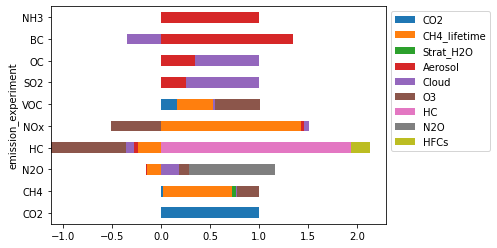

In [29]:
df_coll_t = df_collins.transpose()
if 'Total' in df_coll_t.index:
    df_coll_t = df_coll_t.drop('Total')
# scale by total:
scale = df_coll_t.sum()
# normalized ERF: 
df_col_normalized = df_coll_t / scale
#
df_col_normalized.transpose().plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1, 1))

# Save ERFs

In [30]:
fn_output_ERF

PosixPath('/Users/sarablichner/science/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_out/historic_delta_GSAT/hist_ERF_est.csv')

In [31]:
fn_output_ERF.parent.mkdir(parents=True, exist_ok=True)
df_ERF.to_csv(fn_output_ERF)
df_col_normalized.to_csv(fn_output_decomposition)
df_collins.to_csv(fn_output_ERF_2019)

In [32]:
df_ERF

,CO2,N2O,CH4,NOx,SO2,BC,OC,NH3,VOC,HC
1750,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000
1751,0.001126,0.000078,0.000824,-0.000001,-0.000055,0.000024,-0.000125,-0.000005,0.000174,0.000000
1752,0.002252,0.000155,0.001647,-0.000002,-0.000095,0.000049,-0.000249,-0.000010,0.000348,0.000000
1753,0.003378,0.000233,0.002471,-0.000003,-0.000130,0.000073,-0.000373,-0.000016,0.000521,0.000000
1754,0.004505,0.000310,0.003294,-0.000004,-0.000167,0.000097,-0.000497,-0.000021,0.000694,0.000000
...,...,...,...,...,...,...,...,...,...,...
2015,1.894420,0.225867,1.160556,-0.274934,-1.038115,0.111334,-0.211918,-0.032429,0.473219,0.205775
2016,1.948068,0.229055,1.169129,-0.271339,-0.995462,0.109283,-0.212355,-0.032766,0.456502,0.206995
2017,1.981696,0.232610,1.176556,-0.271009,-0.958711,0.109212,-0.212410,-0.033141,0.449865,0.208398
2018,2.019078,0.237074,1.185527,-0.269076,-0.953242,0.108447,-0.210940,-0.033449,0.444873,0.210010
